# Herron Topic 6 - Size, Value, and Momentum Investing

This lecture notebook covers momentum investing, and the practice notebook will apply the tools we learn in this notebook to size and value investing.
Here, we will learn:

1. What is momentum investing?
1. How to use Center for Research in Security Prices (CRSP) data, which is survivorship bias free
1. How to implement and evaluate a momentum strategy

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%config InlineBackend.figure_format = 'retina'
%precision 4
pd.options.display.float_format = '{:.4f}'.format

In [3]:
import yfinance as yf
import pandas_datareader as pdr
import requests_cache
session = requests_cache.CachedSession()

## What is momentum investing?

From page 13 of [chapter 12](https://book.ivo-welch.info/read/source5.mba/12-effbehav.pdf) of Ivo Welch's free corporate finance textbook (***emphasis added***):

> The second-most important factor anomaly was the momentum investing strategy.
***Momentum investing strategies require going long in stocks that have increased
greatly over the last year, and going short in stocks that have decreased greatly.***
(It requires a few more contortions, but this is a reasonable characterization.) As
with value, behavioral finance researchers were quick to adopt momentum as a
consequence of investor psychology. They also developed plenty of theories that
argued about how the psychology of investors could explain momentum.
>
> Yet over the last 17 years, Ken French’s data suggests that the average rate of Momentum has been mostly
return on the momentum investment strategy was — drumroll — 0.03% with a
standard deviation of 23.8%. This rate of return is statistically and economically
insignificant. Momentum investing also had the unpleasant aspect of sudden nasty
risk. It lost 83 cents for every dollar invested in 2009

## CRSP Data

We typically use Yahoo! Finance data in class because these data are easy to download and use.
However, Yahoo! Finance only provides data for listed (active) public companies.
When public companies delist, Yahoo! Finance removes their data from its website and application programming interfaces (APIs).
Companies delist for various reasons, including failures, poor performance, buyouts, and acquisitions.
Failures and poor performance are generally associated with large negative returns before delisting.
Buyouts and acquisitions are generally associated with large positive returns before delisting.
Regardless of the reason for delisting, delisted company data are unavailable from Yahoo! Finance.
Because delistings are not randomly assigned and typically related to past performance, we cannot ignore them.
If we ignore delistings, we create a [survivorship bias](https://en.wikipedia.org/wiki/Survivorship_bias):


> Survivorship bias, survival bias or immortal time bias is the logical error of concentrating on the people or things that made it past some selection process and overlooking those that did not, typically because of their lack of visibility. This can lead to incorrect conclusions regarding that which (or those who) didn't make it.
>
> Survivorship bias is a form of selection bias that can lead to overly optimistic beliefs because multiple failures are overlooked, such as when companies that no longer exist are excluded from analyses of financial performance. It can also lead to the false belief that the successes in a group have some special property, rather than just coincidence as in correlation "proves" causality. For example, if 3 of the 5 students with their state's highest college GPAs went to the same high school, it might lead to the notion (which the institution may even capitalize on through advertising) that their high school offers an excellent education even though it's actually due to their school being the largest in their state. Therefore, by comparing the average GPA of all of the school's students — not just the ones who made the top-five selection process — to state averages, one could better assess the school's quality (not quantity).
> 
> Another kind of survivorship bias would involve thinking that an incident was not all that dangerous because the only people who were involved in the incident who can speak about it are those who survived it. Even if one knew that some people are dead, they would not have their voice to add to the conversation, leading to bias in the conversation. 

We should always be on the lookout for survivorship bias!
Here is my favorite survivorship bias joke: 


![XKCD 1827](https://imgs.xkcd.com/comics/survivorship_bias.png)

To avoid a survivorship bias, we will use survivorship-bias-free data from the [Center for Research in Security Prices (CRSP)](https://www.crsp.org/).
CRSP data include delisted stocks and are used by academics and institutional investors to research and backtest trading strategies.
Download the CRSP data file `crsp.csv` from Canvas, and put it in the same folder as this notebook.
Then, we can read and clean the CRSP data file as follows.

In [4]:
crsp = (
    pd.read_csv(
        filepath_or_buffer='crsp.csv',
        parse_dates=['date'],
        na_values=['A', 'B', 'C'] # CRSP uses letter codes to provide additional information, which we can ignore
    )
    .assign(date=lambda x: x['date'].dt.to_period(freq='M')) # returns span a month, so I prefer to work with periods instead of dates
    .rename_axis(columns='Variable')
    .set_index(['PERMNO', 'date'])
)

The CRSP data files contains a small subset of all available CRSP data:

1. `PERMNO` indicates permanent security identifiers, which is more reliable than tickers, which may change or be re-used by a different firm
1. `date` indicates the last trading day of the month, which we convert to a year-month "period"
1. `SHRCD` indicates share classes (e.g., A, B, and preferred), which I filtered to values of 10 or 11
1. `PRC` indicates the closing price on the last trading day of the month, and `PRC` is negative if it is the mean of the bid and ask prices instead of a price from an observed trade
1. `RET` indicates the holding period return as a simple return, including dividends
1. `SHROUT` indicates the number of shares outstanding in thousands (e.g., a `SHROUT` value of 1,000 indicates 1,000,000 shares)

In [5]:
crsp.head()

Variable        SHRCD     PRC     RET    SHROUT
PERMNO date                                    
10000  1986-01     10 -4.3750     NaN 3680.0000
       1986-02     10 -3.2500 -0.2571 3680.0000
       1986-03     10 -4.4375  0.3654 3680.0000
       1986-04     10 -4.0000 -0.0986 3793.0000
       1986-05     10 -3.1094 -0.2227 3793.0000

These CRSP data are de-duplicated, but we should double-check for duplicate PERMNO-date pairs with the `.duplicated()` method.

In [6]:
assert not crsp.index.duplicated().any()

For fun, we can use these data to count the number of listed stocks each month and plot the trend of publicly listed stocks.

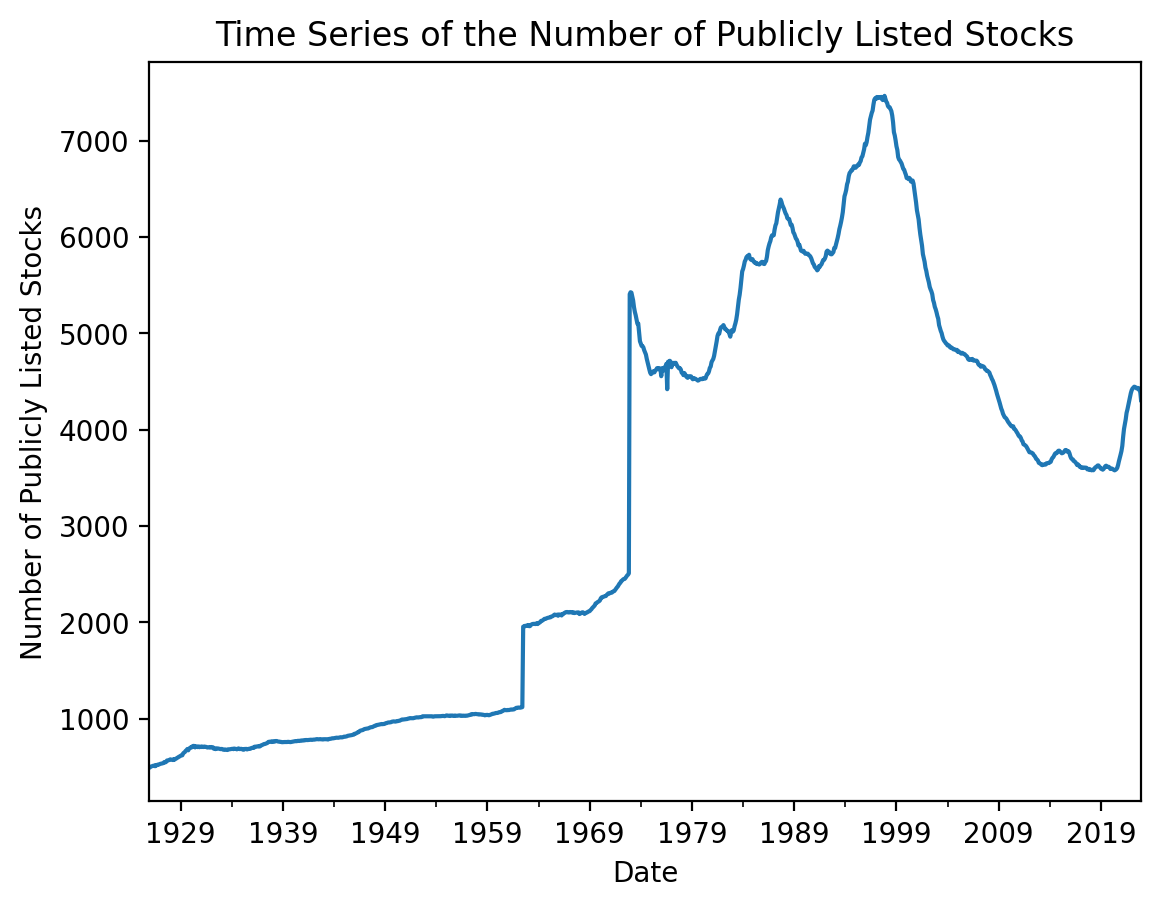

In [7]:
crsp.reset_index('PERMNO').resample('M')['PRC'].count().plot()
plt.xlabel('Date')
plt.ylabel('Number of Publicly Listed Stocks')
plt.title('Time Series of the Number of Publicly Listed Stocks')
plt.show()

## Implement a Momentum Investing Strategy

We will implement a momentum investing strategy with 1-month holding periods of equal-weighted portfolios formed on total returns from month -12 through month -2.
For example, at the start of January in year $t$, we assign stocks to 10 portfolios based on their total returns from January in year $t-1$ through November in year $t-1$.
Portfolio 1 has the lowest trailing returns, and portfolio 10 has the highest trailing returns.
We do not use the returns in month -1 for portfolio assignment because they would contaminate our portfolio returns with [bid-ask bounce](https://www.investopedia.com/ask/answers/013015/whats-difference-between-bidask-spread-and-bidask-bounce.asp).
For example, in our example above, we do not use returns from December in year $t-1$ to assign stocks to portfolios at the start of January in year $t$.

### Calculate 1-Month and 11-Month Returns

We will assign 1-month returns in month 0 to data frame `ret_1m`.
This calculation is easier in the wide format, but we will later use the long format.

In [8]:
ret_1m = crsp['RET'].unstack('PERMNO')

ret_1m.tail()

PERMNO,10000,10001,10002,10003,10005,10006,10007,10008,10009,10010,...,93423,93426,93428,93429,93430,93432,93433,93434,93435,93436
date,,,,,,,,,,,,,,,,,,,,,
2022-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.0229,0.1004,NaN,-0.0400,NaN,NaN,NaN,0.3474,NaN,-0.0725
2022-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.2009,-0.1376,NaN,-0.0051,NaN,NaN,NaN,-0.4297,NaN,-0.0376
2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.2599,0.1406,NaN,0.0607,NaN,NaN,NaN,0.3562,NaN,-0.1422
2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0803,0.2021,NaN,0.0228,NaN,NaN,NaN,0.1212,NaN,-0.1443
2022-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.0349,-0.0473,NaN,-0.0108,NaN,NaN,NaN,0.3423,NaN,-0.3673


We will assign 11-month returns from month -12 to month -2 to data frame `ret_11m`.
The `.rolling()` method does not have a `.prod()` method, so we will sum log returns instead of compounding simple returns, which speeds up our calculation.

In [9]:
ret_11m = ret_1m.pipe(np.log1p).rolling(11).sum().pipe(np.expm1)

ret_11m.tail()

PERMNO,10000,10001,10002,10003,10005,10006,10007,10008,10009,10010,...,93423,93426,93428,93429,93430,93432,93433,93434,93435,93436
date,,,,,,,,,,,,,,,,,,,,,
2022-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.4788,-0.0132,NaN,-0.0321,NaN,NaN,NaN,-0.5058,NaN,0.0662
2022-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.5697,-0.1320,NaN,-0.0960,NaN,NaN,NaN,-0.8298,NaN,-0.2857
2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.3902,-0.0169,NaN,-0.0224,NaN,NaN,NaN,-0.6610,NaN,-0.4037
2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.4342,0.0929,NaN,-0.0113,NaN,NaN,NaN,-0.5934,NaN,-0.4473
2022-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.4112,0.2067,NaN,0.0760,NaN,NaN,NaN,-0.3578,NaN,-0.6055


We should always check our work!
If we were to use this code in a production environment (i.e., run it frequently to make decisions), we would add [unit tests](https://en.wikipedia.org/wiki/Unit_testing) to check our work.
We can use `PERMNO` 10010 to (very lightly) check our work.

In [10]:
assert np.allclose(
    a=ret_1m[10010].rolling(11).apply(lambda x: (1 + x).prod() - 1),
    b=ret_11m[10010],
    equal_nan=True
)

### Assign Stocks to Portfolios Based on 11-Month Returns

We will use `pd.qcut()` to assign stocks to portfolios based on their 11-month trailing returns.
Here is a simple example that uses `pd.qcut()` to assign the values 0 to 24 to 10 portfolios.

In [11]:
pd.qcut(np.arange(25), q=10, labels=False) + 1

array([ 1,  1,  1,  2,  2,  3,  3,  3,  4,  4,  5,  5,  5,  6,  6,  7,  7,
        8,  8,  8,  9,  9, 10, 10, 10])

We will save these portfolio assignments to data frame `port_11m`.
The `pd.qcut()` function errs if we try to cut an array of all missing values, so we will use `.dropna(how='all')` to drop rows with all missing values.

In [12]:
port_11m = ret_11m.dropna(how='all').apply(pd.qcut, q=10, labels=False, axis=1) + 1

port_11m.tail()

PERMNO,10000,10001,10002,10003,10005,10006,10007,10008,10009,10010,...,93423,93426,93428,93429,93430,93432,93433,93434,93435,93436
date,,,,,,,,,,,,,,,,,,,,,
2022-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0000,7.0000,NaN,7.0000,NaN,NaN,NaN,3.0000,NaN,9.0000
2022-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0000,7.0000,NaN,8.0000,NaN,NaN,NaN,1.0000,NaN,6.0000
2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0000,7.0000,NaN,7.0000,NaN,NaN,NaN,2.0000,NaN,4.0000
2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0000,9.0000,NaN,7.0000,NaN,NaN,NaN,3.0000,NaN,4.0000
2022-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0000,9.0000,NaN,9.0000,NaN,NaN,NaN,4.0000,NaN,2.0000


Again. we should check our output, here with the last row of data.

In [13]:
assert np.allclose(
    a=port_11m.iloc[-1],
    b=pd.qcut(x=ret_11m.iloc[-1], q=10, labels=False) + 1,
    equal_nan=True
)

### Combine Returns and Portfolio Assignments

Next, we will use `pd.concat(axis=1)` to match returns and portfolio assignments.
We must `.shift(2)` the 11-month returns and portfolios assignments to avoid a look-ahead bias and drop month -1 returns.

1. The first shift makes sure we do not use contemporaneous returns to assign stocks to portfolios (i.e., otherwise the portfolio ranking and portfolio returns would overlap).
1. The second shift avoids mechanical correlations between returns one month and the next (i.e., bid-ask bounce and market microstructure noise).

In [14]:
mom_0 = (
    pd.concat(
        objs=[ret_1m, ret_11m.shift(2), port_11m.shift(2)],
        axis=1, 
        keys=['Return', 'Return_Trailing', 'Portfolio'],
        names=['Variable', 'PERMNO']
    )
    .stack('PERMNO')
    .dropna()
    .assign(Portfolio=lambda x: x['Portfolio'].astype(int))
)

In [15]:
mom_0.head()

Variable        Return  Return_Trailing  Portfolio
date    PERMNO                                    
1927-01 10022  -0.0759           0.1182          8
        10030   0.0095           0.0093          6
        10057  -0.0510          -0.5918          1
        10073   0.0946          -0.4286          2
        10081  -0.0750          -0.4194          2

### Evaluate Performance

Is there a relation between returns from month -12 to month -2 and return in month 0?
We can use the `.corr()` to estimate this.

In [16]:
mom_0.filter(regex='Return').corr()

Variable,Return,Return_Trailing
Variable,,
Return,1.0000,0.0036
Return_Trailing,0.0036,1.0000


This correlation is very weak!
But we expect we correlations based on pervious course topics.
We can try again with log returns, which may reduce the noise from outliers.
Recall $R_{Log} = log(1 + R_{Simple})$, which we can quickly implement with `.pipe(np.log1p)`.

In [17]:
mom_0.filter(regex='Return').pipe(np.log1p).corr()

Variable,Return,Return_Trailing
Variable,,
Return,1.0000,0.0486
Return_Trailing,0.0486,1.0000


The correlation of log returns is larger, but still low because single-stock returns are noisy!
We can reduce this noise with portfolios formed on trailing returns.
We will equally weight the returns in each portfolio using `.mean()`.

In [18]:
mom_ew = (
    mom_0
    .groupby(by=['date', 'Portfolio'])
    ['Return']
    .mean()
    .unstack('Portfolio')
)

In [19]:
mom_ew.head()

Portfolio,1,2,3,4,5,6,7,8,9,10
date,,,,,,,,,,
1927-01,-0.0006,0.0149,0.0407,0.0378,0.0009,0.0150,0.0124,0.0076,-0.0044,0.0126
1927-02,0.0641,0.0484,0.0866,0.0745,0.0480,0.0547,0.0561,0.0403,0.0579,0.0541
1927-03,-0.0530,-0.0381,-0.0243,-0.0408,-0.0192,-0.0201,0.0108,-0.0084,-0.0058,0.0012
1927-04,0.0207,-0.0085,-0.0054,-0.0061,0.0002,-0.0032,0.0137,0.0030,0.0307,0.0421
1927-05,0.0069,0.0353,0.0604,0.0635,0.0700,0.0950,0.0796,0.0838,0.0803,0.0886


Next, we will plot the mean return for each portfolio.
We will convert these equal-weighted portfolio returns to percent, but leave them as monthly values.

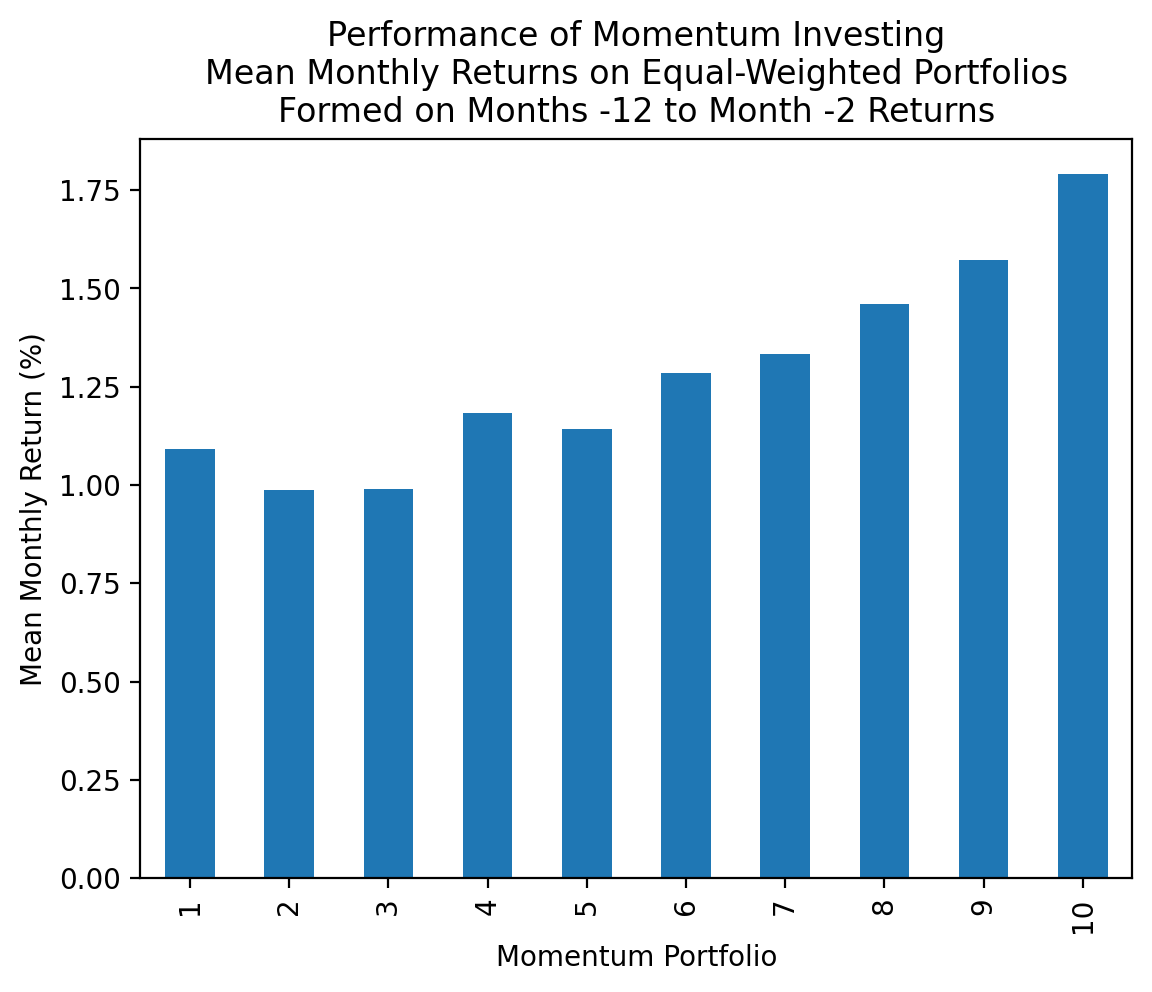

In [20]:
mom_ew.mean().mul(100).plot(kind='bar')
plt.ylabel('Mean Monthly Return (%)')
plt.xlabel('Momentum Portfolio')
plt.title(
    'Performance of Momentum Investing' +
    '\nMean Monthly Returns on Equal-Weighted Portfolios' +
    '\nFormed on Months -12 to Month -2 Returns'
)
plt.show()

Above, we see about a 75 basis point spread between the returns on portfolios 1 and 10, suggesting that momemtum investing generates excess returns.
We should also consider cumulative returns over holding periods longer than one month.
Next, we will plot the values of $1 invested in each portfolio.

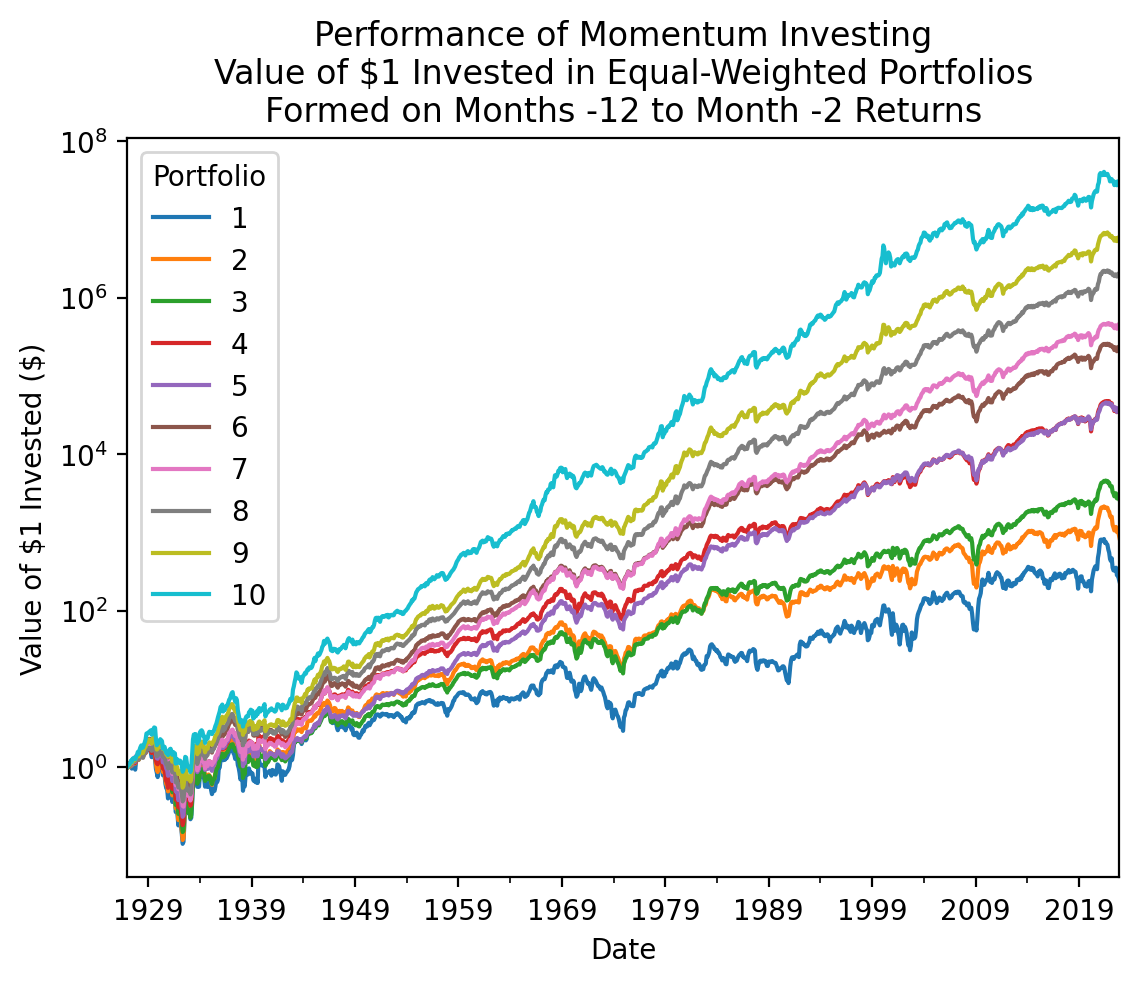

In [21]:
mom_ew.add(1).cumprod().plot()
plt.semilogy()
plt.ylabel('Value of \$1 Invested (\$)')
plt.xlabel('Date')
plt.title(
    'Performance of Momentum Investing' +
    '\nValue of $1 Invested in Equal-Weighted Portfolios' +
    '\nFormed on Months -12 to Month -2 Returns'
)
plt.show()

Finally, we can estimate capital asset pricing model (CAPM) and Fama-French four-factor model (FF4) regressions.

In [22]:
ff_0 = pdr.DataReader(
    name='F-F_Research_Data_Factors',
    data_source='famafrench',
    session=session,
    start='1900'
)

ff_0[0].head()

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07,2.9600,-2.5600,-2.4300,0.2200
1926-08,2.6400,-1.1700,3.8200,0.2500
1926-09,0.3600,-1.4000,0.1300,0.2300
1926-10,-3.2400,-0.0900,0.7000,0.3200
1926-11,2.5300,-0.1000,-0.5100,0.3100


In [23]:
ff_mom = pdr.DataReader(name='F-F_Momentum_Factor', data_source='famafrench', session=session, start='1900')
ff_mom[0].columns = [c.strip() for c in ff_mom[0].columns]

ff_mom[0].head()

,Mom
Date,
1927-01,0.3600
1927-02,-2.1400
1927-03,3.6100
1927-04,4.3000
1927-05,3.0000


In [24]:
import statsmodels.formula.api as smf

In [25]:
def capm(c, df):
    return smf.ols(formula=f'I(Q({c}) - RF) ~ Q("Mkt-RF")', data=df)

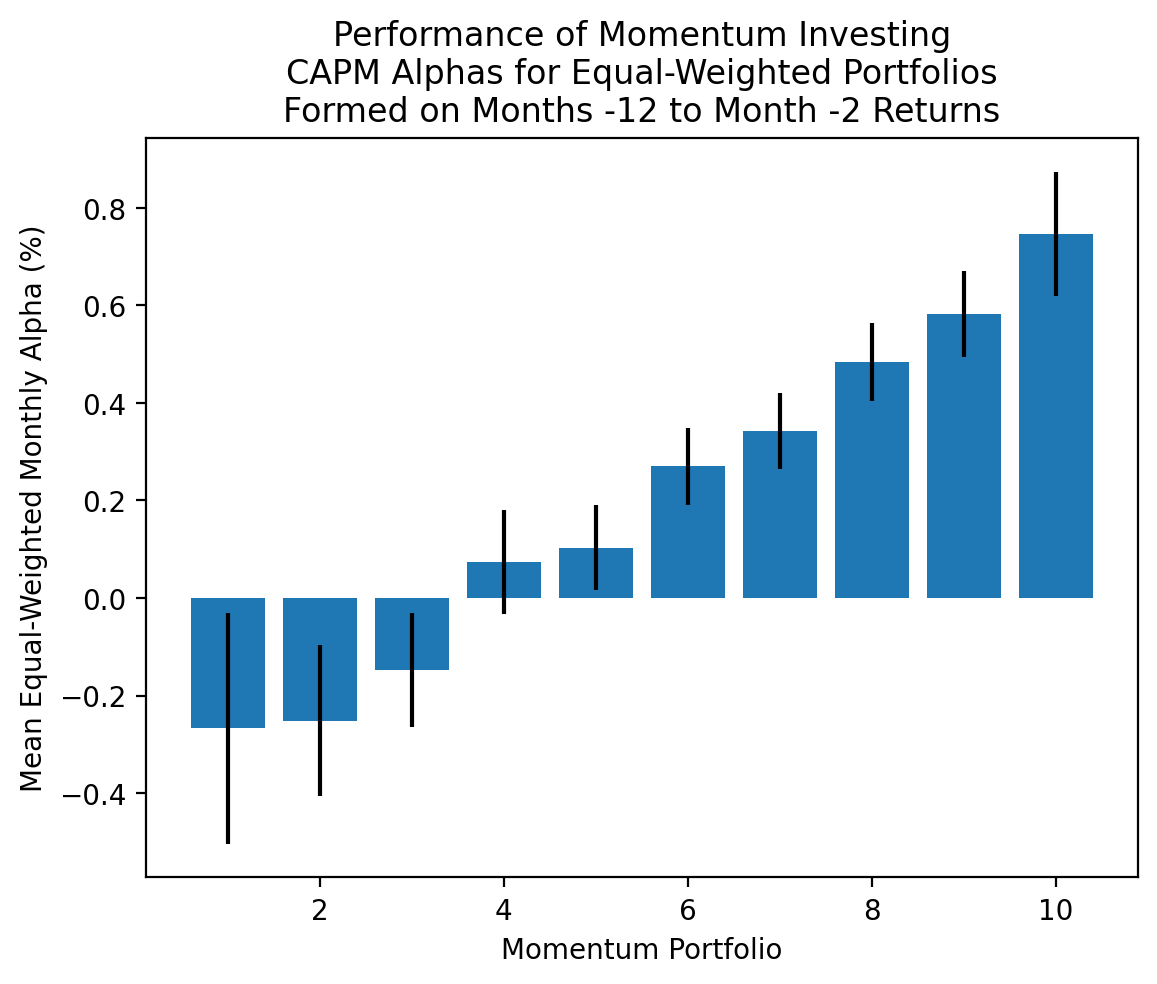

In [26]:
_ = mom_ew.mul(100).join(ff_0[0])
models = [capm(c=c, df=_) for c in mom_ew.columns]
fits = [m.fit() for m in models]
params = pd.concat([f.params for f in fits], axis=1, keys=mom_ew.columns).T
bses = pd.concat([f.bse for f in fits], axis=1, keys=mom_ew.columns).T

plt.bar(
    x=params.index,
    height=params['Intercept'],
    yerr=bses['Intercept']
)

plt.ylabel('Mean Equal-Weighted Monthly Alpha (%)')
plt.xlabel('Momentum Portfolio')
plt.title(
    'Performance of Momentum Investing' +
    '\nCAPM Alphas for Equal-Weighted Portfolios' +
    '\nFormed on Months -12 to Month -2 Returns'
)
plt.show()

In [27]:
def ff4(c, df):
    return smf.ols(formula=f'I(Q({c}) - RF) ~ Q("Mkt-RF") + SMB + HML + Mom', data=df)

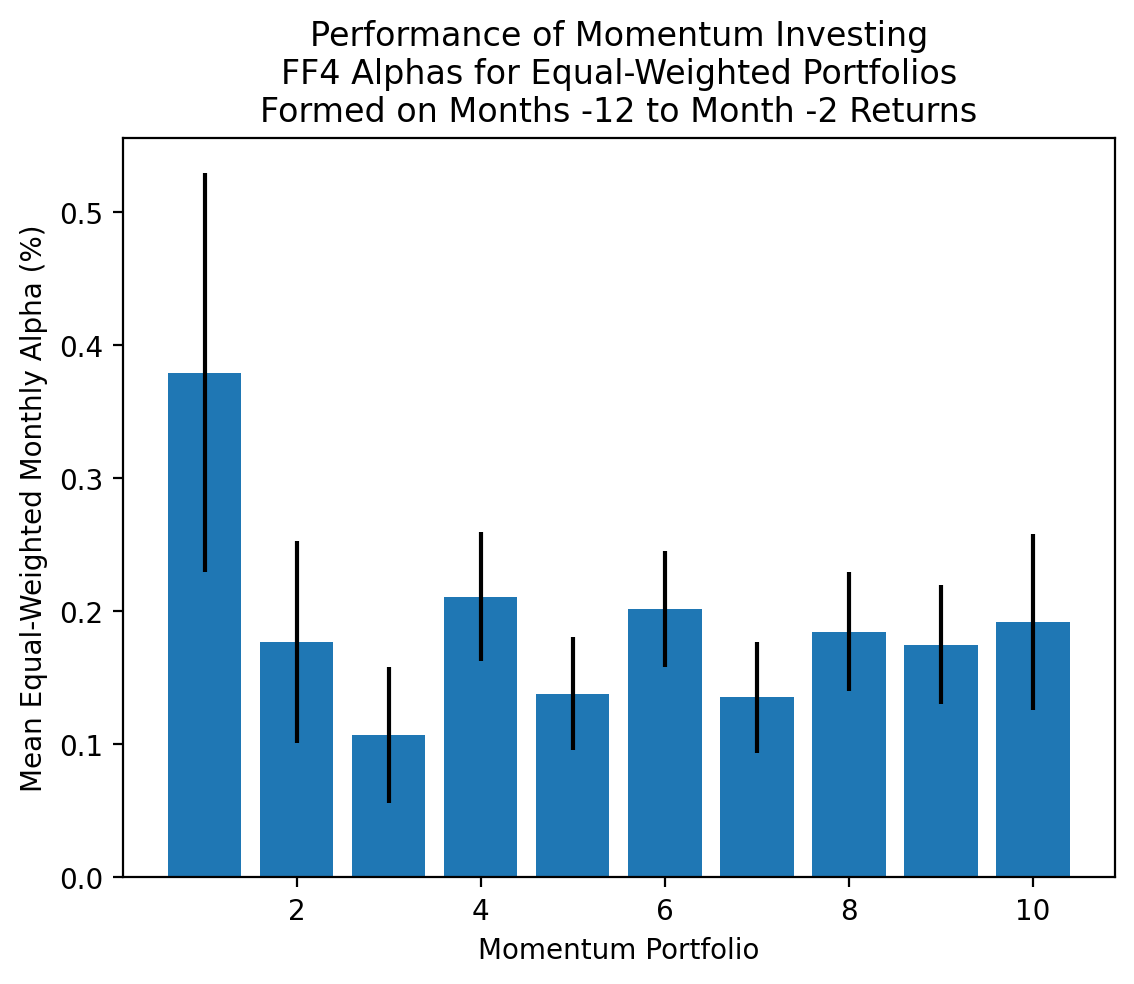

In [28]:
_ = mom_ew.mul(100).join([ff_0[0], ff_mom[0]])
models = [ff4(c=c, df=_) for c in mom_ew.columns]
fits = [m.fit() for m in models]
params = pd.concat([f.params for f in fits], axis=1, keys=mom_ew.columns).T
bses = pd.concat([f.bse for f in fits], axis=1, keys=mom_ew.columns).T

plt.bar(
    x=params.index,
    height=params['Intercept'],
    yerr=bses['Intercept']
)

plt.ylabel('Mean Equal-Weighted Monthly Alpha (%)')
plt.xlabel('Momentum Portfolio')
plt.title(
    'Performance of Momentum Investing' +
    '\nFF4 Alphas for Equal-Weighted Portfolios' +
    '\nFormed on Months -12 to Month -2 Returns'
)
plt.show()

In the FF4 model above, the alphas are abnormally large because we use equal-weighted portfolios, which overweight small stocks.
Because these portfolios overweight small stocks, these alphas make be associated with liquidity and difficult to earn at scale.
In the practice notebook, we will explore value-weighted portfolios and size investing strategies.